# Linear least squares fit - Yago Obispo Gerster | mn304 | yago.obispo_gerster@stud.uni-heidelberg.de

## Tasks

Perform a least squares fit of a parabola

$$ y(x) = \theta_0 + \theta_1 x + \theta_2 x^2$$

for the seven independent measurments $(x_i, y_i)$ given by $(-0.75, 1.0 \pm 1.0)$, $(-0.5, 4.0 \pm 1.0)$, $(-0.25, 4.0 \pm 0.5)$, $(0.0, 5.5 \pm 0.5)$, $(0.25, 4.5 \pm 0.5)$, $(0.5, 5.5 \pm 1.0)$, $(0.75, 3.0 \pm 1.0)$. 

a) Determine the best fit parameters $\hat \theta_i$ and their covariances using the formula for linear least squares fits.

b) Determine the $\chi_\mathrm{obs}^2$ for the best fit parameter. What is the number of degrees of freedom? Plot the $\chi^2$ distribution and indicate $\chi_\mathrm{obs}^2$ in this plot (e.g. by drawing a line at this value).
What is the $p$-value for this fit?

c) Plot the fitted parabola and the $1\sigma$ error band around it as obtaind from the error propagation formula $\sigma_y^2 = A^\mathrm{T} U A$. What is the predicted value $y$ at $x=1$ and its uncertainty?

d) Compare the fit result and the covariance matrix with the results obtained with iminuit. Do the results agree?

e) Determine the $p$-value for a straight-line fit. Is thhis an acceptable description of the data?


### Hints

1) The following numpy functions might come in very handy
* diagonal matrix from vector v in numpy: *A = np.diagflat(v)*
* matrix from column vectors v0, v1, v2: *A = np.column_stack((v0, v1, v2))*
* multiplication of matrices A and B in numpy: *C = A.dot(B)*
* transposed matrix: *A_T = np.transpose(A)*
* inverse matrix: *A_inv = inv(A)*, this requires *from numpy.linalg import inv*

2) It might be useful to write a function which returns the uncertainty $\sigma_y$ for a numpy array of $x$ values. A function $f$ that only works for a scalar value $x$ can be vectorized (i.e., it works also for numpy arrays) with *numpy.vectorize*.

3) Data points with error bars can be drawn with *plt.errorbar(x, y, yerr=sigma_y)*

4) A band between $y$ values can be drawn with the aid of *matplotlib.pyplot.fill_between*

## Comments on Python's `iminuit`

The KIP service has iminuit version 1.3.8. Please note that the most recent version is $\geq2.0.0$ and that the [documentation](https://iminuit.readthedocs.io/en/stable/) applies to *that* version. Some backward-incompatible changes have been introduced, some of which changed some interfaces. For your tasks that mainly affects the `minuit.Minuit` constructor. The following shows the construction of a `Minuit` object for version 1.3.8 (in case you use the KIP service or a version $<2.0.0$) and $\geq2.0.0$ (in case you use another service implementing a higher version), respectively.
```python
from iminuit import Minuit

def func(par1, par2, ..., parN):
    return minimise_something(par1, par2, ..., parN)

# least squares method: errordef=1
# likelihood method: errordef=0.5
m = Minuit(func, par1=0.1, par2=0.1, ..., parN=0.1, errordef=1)
```

And this would be the equivalent workflow for versions >2.0.0
```python
from iminuit import Minuit

def func(par1, par2, ..., parN):
    return minimise_something(par1, par2, ..., parN)

# least squares method: errordef=Minuit.LEAST_SQUARES
# likelihood method: errordef=Minuit.LIKELIHOOD

# add errordef as an attribute of your defined minimisation function which will be checked for when optimised
func.errordef = Minuit.LEAST_SQUARES
m = Minuit(func, par1=0.1 par2=0.1, ..., parN=0.1)
```

Another (potenitally) Jupiter related *feature* is the fact that `m.migrad()`, `m.matrix()`, `m.minos()` etc. can yield a nice summary of the respective procedure. However, in order to show it, either of these methods (and potentially others in case you use them) have to be *the last line of a code cell*. If there is *anything* coming afterwards, the output will not be printed, hence, for anything that follows, it is recommended to start a new code cell.


## Solution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from iminuit import Minuit

#Modules for more visual outputs
from sympy import *
from IPython.display import display, Latex

#Module for numerival integration
from scipy.integrate import quad

#Module in order to compute gamma function
import math

In [2]:
# given data
x = np.array([-0.75, -0.5, -0.25, 0., 0.25, 0.5, 0.75])
y = np.array([1., 4.0, 4., 5.5, 4.5, 5.5, 3])
sigma_y = np.array([1, 1, 0.5, 0.5, 0.5, 1, 1])

## Excercise a: Fit parameters and covariances

Seven independent measurements $(x_i,y_i)$ have been made and the goal is to fit a parabola to the measured data of the form:
$$ f(\vec \theta,x) = \theta_0 + \theta_1 x + \theta_2 x^2$$
We can observe, that our fit function is linear in all our model parameters $\theta_i$. Therefore the known formulas for the linear least squares method can be applied.

Generally, we can apply a linear least squares fit to functions of the form:
$$ f(\vec \theta,x) = \sum\limits_{k=1}^m a_k(x)\theta_k $$
By comparison of coefficients we get $a_i(x)=x^i$. The coefficients define the matrix $A_{ij} = a_j(x_i) = (x_i)^j$.
The $\chi^2$ function can then be written as
$$ \chi^2 = \left( \vec{y}- A \cdot \vec{\theta} \right)^T \cdot C^{-1} \cdot \left( \vec{y}- A \cdot \vec{\theta} \right) $$
where $\vec y$ is a seven dimensional vector which carries the y measurements and $C$ is the covariance matrix - which here by assumption is a diagonal matrix with the variances on the diagonal.
The $\chi^2$ function is minimal for:
$$ \vec{\hat \theta} = \left(A^TC^{-1}A\right)^{-1}A^TC^{-1}\cdot\vec{y} $$
Obviously we are interested in the model values which minimize the $\chi^2$ function, as they are the best model parameters for the description of the sample.

We define the matrix which transforms between $\vec{y}$ and $\vec{\hat \theta}$ as $G$:
$$ G := \left(A^TC^{-1}A\right)^{-1}A^TC^{-1}$$
$$ \Rightarrow \vec{\hat \theta} = G \vec{y}$$
The covariance matrix $M$ of the estimated model parameters can be computed by a congruence transformation:
$$ M = \left(A^TC^{-1}A\right)^{-1} = G C G^T $$

In [3]:
#Define matrices A and C
A = np.column_stack((x ** 0,x,x ** 2))
C = np.diagflat(sigma_y**2)

#Compute the covariance matrix M
M = inv(np.transpose(A).dot(inv(C).dot(A)))

#Compute the matrix G with def. above subsituting M
G = M.dot(np.transpose(A).dot(inv(C)))

#Determine best fit parameters
th_fit = G.dot(y)

#Output
display(Latex('${} = {} $'.format('\\vec{\hat\\theta}',latex(Matrix(th_fit.round(3))))))
display(Latex('$M = {}$'.format(latex(Matrix(M.round(3))))))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Excercise b: $\chi^2$ Distribution
In the next step the $\chi_{obs}^2$ value for the found minimalizing model parameters will be calculated.
As mentioned before, we get the $\chi^2$ by using:
$$ \chi^2 = \left( \vec{y}- A \cdot \vec{\theta} \right)^T \cdot C^{-1} \cdot \left( \vec{y}- A \cdot \vec{\theta} \right) $$
In order to compute $\chi_{obs}^2$ we therefore just have to plug in our vector for the minimalizing model parameters $\vec{\hat\theta}$:

In [4]:
#Plug th_fit into formula for chi_squared and output
chi_obs_squared = np.transpose(y-A.dot(th_fit)).dot(inv(C)).dot(y-A.dot(th_fit))
display(Latex("$${} = {}$$".format("\chi_{obs}^2", latex(np.round(chi_obs_squared,3)))))

<IPython.core.display.Latex object>

The number of degrees of freedom is given by subtracting the number of model parameters $m$ from the total number of measurements $n$, as we have already estimated the model parameters and have therefore consumed $m$ degrees of freedom.
$$ n_F = n-m = 7-3=4$$
Hence we have 4 degrees of freedom.
The probability density function for $\chi^2$ with $n$ degrees of freedom is given by:
$$ f(\chi^2,n) =\frac{(\chi^2)^{n/2-1}e^{-(\chi^2)/2}}{2^{n/2}\Gamma(\frac{n}{2})}  $$
As we know that for $n\in \mathbb{N}: \Gamma(n)=(n-1)!$ for $n=4$ we get:
$$ f(\chi^2,4) =\frac{(\chi^2)e^{-(\chi^2)/2}}{4}  $$
We can plot this distribution and signal the point at which the estimated $\chi_{obs}^2$ value is:

Text(0, 0.5, '$\\chi^2$ probability density')

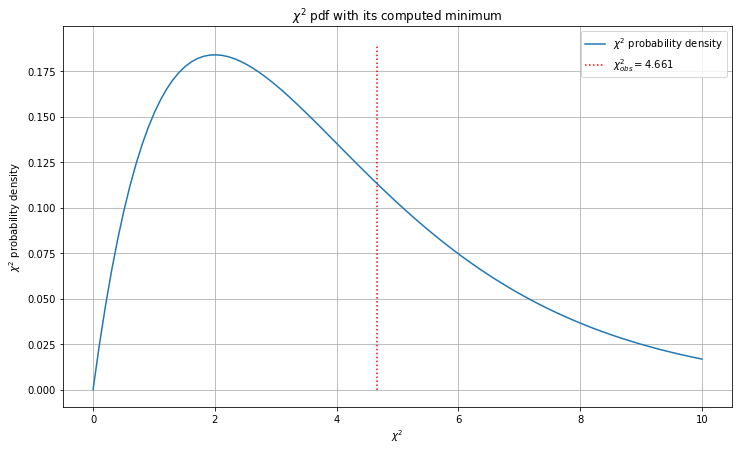

In [5]:
#Define the chi_squared function with the formula for n=4 above
def chi_squared_pdf(chi_squared):
    return chi_squared*np.exp(-chi_squared/2)/4

#Plot
c=np.linspace(0,10, 100)
plt.figure(figsize=(12,7))
plt.title(r'$\chi^2$ pdf with its computed minimum')
plt.plot(c, chi_squared_pdf(c), label=r'$\chi^2$ probability density')
plt.grid()
plt.vlines(chi_obs_squared,0,0.19, linestyle = "dotted",color='red', label='${} ={}$'.format(r"""\chi^2_{obs}""",np.round(chi_obs_squared,3)))
plt.legend()
plt.xlabel(r'$\chi^2$')
plt.ylabel(r'$\chi^2$ probability density')

By definition, the $p$-value can be determined by using:
$$ p-value = 1- \int_0^{\chi^2_{obs}} P(\chi^2) \ \text{d}\chi^2 $$
It describes the probability of obtaining a worse value than the observed $\chi^2$.

In [6]:
p = 1- quad(chi_squared_pdf, 0, chi_obs_squared)[0]
display(Latex('$p-value = {}$'.format(np.round(p,3))))

<IPython.core.display.Latex object>

An often used (arbitrary) argument in order to analyze if a model describes the sample or needs to be discarded, is $p<0.05$. So if the probability is less than $5\%$, the model needs to be discarded. However, our p-value has a magnitude of $0,324$, which means, our model fits the data correct.
Hence, a quadratic function is appropriate for our sample.

## Excercise c: Fitted parabola and $1\sigma$ error band

We have already computed the best fit parameters for a parabola. We can therefore plot the parabola and also highlight the $1\sigma$ error band obtained by the formula $\sigma_y^2 = A^\mathrm{T} M A$

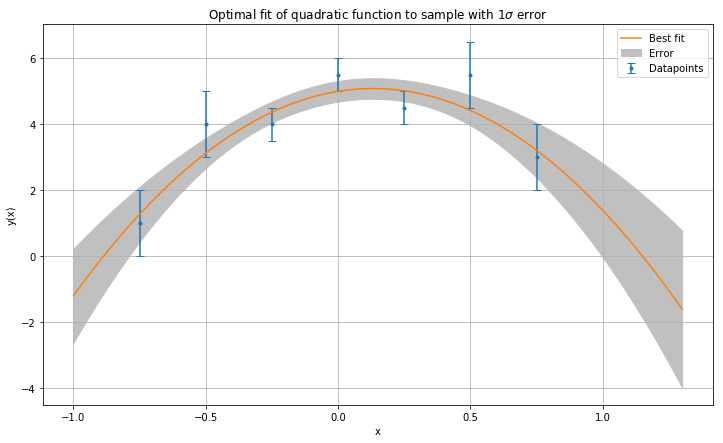

In [7]:
#Define the fit function: quadratic
def quadratic(x,th_1,th_2,th_3):
    return th_1 + th_2*x + th_3*x**2

#Formula for sigma_y above
def sig_y(x):
    A = np.array([1, x, x** 2], dtype='object')
    return np.sqrt(np.transpose(A).dot(M).dot(A))

#Plot the quadratic best fit
xt = np.linspace(-1, 1.3, 1000)
plt.figure(figsize=(12,7))
plt.title("Optimal fit of quadratic function to sample with 1$\sigma$ error")
plt.grid()
plt.xlabel('x')
plt.ylabel('y(x)')

#Datapoints with its errors
plt.errorbar(x, y, yerr=sigma_y, capsize=4, fmt='.', label='Datapoints')

#Plot parabola
plt.plot(xt, quadratic(xt, th_fit[0], th_fit[1], th_fit[2]), label='Best fit')

#Highlight the 1sigma area around parabola by adding ans subtracting sig_y to the function
plt.fill_between(xt,quadratic(xt,th_fit[0],th_fit[1],th_fit[2])+sig_y(xt),
                 quadratic(xt,th_fit[0],th_fit[1],th_fit[2])-sig_y(xt),
                 color='silver', label='Error')
plt.legend()

The fit can now be used in order to predict values $y$ for a given $x$ and their respective error margin.
For $x=1$, we obtain:

In [8]:
y_at1 = quadratic(1,th_fit[0],th_fit[1],th_fit[2])
sig_y_at_1 = sig_y(1)

#Display considering significant digits
display(Latex('$y(1) = {}\pm {}$'.format(np.round(y_at1,1),np.round(sig_y_at_1,1))))

<IPython.core.display.Latex object>

## Excercise d: Comparison with Iminuit

The same procedure can be repeated using a different method for computing the fit and the covariance matrix by using the python package Iminuit. Minuit is a package often used in a machine learning context, as it uses fast numerical strategies in order to minimize a function - in our case we are interested in the $\chi^2$ function:
$$ \chi^2 = \sum_{i = 1}^n \dfrac{(y_i - f(x_i, \theta))^2}{\sigma_i^2} $$

In the following, this method will be presented and we will discuss if the results of both methods agree.

In [9]:
#Definition of chi^2 above
def chi_sq(th_0, th_1, th_2):
    return np.sum((y - quadratic(x, th_0, th_1, th_2)) ** 2/ sigma_y ** 2)

#Tell Minuit minimizer chi^2 should be minimized
chi_sq.errordef = Minuit.LEAST_SQUARES

#Initialize a Minuit object to minimize the function and set initial guesses to the parameters, so it converges
m = Minuit(chi_sq, th_0 = 5, th_1 = 0, th_2 = -3)

#Run the minimization process using the MIGRAD algorithm
m.migrad()

#Estimate errors with the HESSE algorithm in order to build the covariance matrix
m.hesse()

#Error analysis with the MINOS algorithm
m.minos()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4.661                      │              Nfcn = 148              │
│ EDM = 6.08e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ th_0 │   4.99    │   0.31    │   -0.31    │    0.31    │         │         │       │
│ 1 │ th_1 │    1.3    │    0.7    │    -0.7    │    0.7     │         │         │       │
│ 2 │ th_2 │   -4.9    │    1.4    │    -1.4    │    1.4     │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │         th_0          │         th_1          │         th_2          │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │   -0.31   │   0.31    │   -0.7    │    0.7    │   -1.4    │    1.4    │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌──────┬───────────────────────────────┐
│      │      th_0      th_1      th_2 │
├──────┼───────────────────────────────┤
│ th_0 │    0.0973 -3.08e-09    -0.262 │
│ th_1 │ -3.08e-09     0.471  1.94e-09 │
│ th_2 │    -0.262  1.94e-09      1.97 │
└──────┴───────────────────────────────┘

As we can see from the Minuit algorithms results, the estimated fit parameters $\vec \theta$ agree in both methods if we round our previous fit parameters.
The covariance matrix is also compatible with our previous results, as the values on the diagonal and the antidiagonal agree. The other values which appear on the Minuit covariance Matrix are in the order of magnitude of $10^{-9}$ and can therefore be neglected, so they agree with our previous values.

## Excercise e: p-value for a straight line fit

In the last excercise, our goal is to determine the p-value for the fit of a straight line to the sample. This will allow us to make a statement about if a linear function is already sufficient for the description of the data (or if we need the second higher order as before).

The procedure is analogous to all the steps discussed in the section with the parabola function fit:

In [10]:
#Define straight line function
def st_line(x,a,b):
    return a*x + b

#Def. matrix A
A = np.column_stack((x**0, x))

#Def. matrix C
C = np.diagflat(sigma_y**2)

#Compute the covariance matrix M
M = inv(np.transpose(A).dot(inv(C).dot(A)))

#Compute the transformation matrix G with def.
G = M.dot(np.transpose(A).dot(inv(C)))

#Best fit parameters
s_fit = G.dot(y)

#chi^2_{obs}
chi_sq_obs = np.transpose(y - A.dot(s_fit)).dot(inv(C).dot(y - A.dot(s_fit)))

# chi^2 with dof=7-2=5, as we now only need 2 fit parameters
def chi_sq(c):
    return c**(1.5)*np.exp(-c/2)/(2**(2.5)* math.gamma(5/2))

# p-value
p_value = 1- quad(chi_sq, 0, chi_sq_obs)[0]
display(Latex('$p-value = {}$'.format(np.round(p_value,3))))

<IPython.core.display.Latex object>

We obtain an extremely small p-value under the threshold of $0.05$. Clearly, we should discard this model and a straight line is insufficient in order to describe the model behind the sample.